# Phase 1. Subphase 2. 

Mario Chacón Falcón & Jose M. Moyano.

The goal of this second experiment is to decide which parameter for public_data_prediction works better, common_abs,common_weighted,own,avg_abs,avg_weighted. 

In order to do so, the rest of the model is fixed to its simplest version, which is:

public_data_prediction = weighted_majority_voting

prediction_weights = 'only_server'

balanced_target_client_weights = False

adapt_client_weights = np.ones(Nclients)

Nclients=10

T (iterations) = 10

To test it out, four datasets are selected, adult dataset (unbalanced), nursery dataset (more than 2 labels), bank and breast_cancer.

The test will be done with 6 different seeds, creating each time 5folds, and hence having 30 tests. The mean over the accuracy and f1score of the FL model of all clients is calculated and stored in a dataframe for further statistics tests. 

In [1]:
from flextrees.datasets.tabular_datasets import bank
from flextrees.datasets.tabular_datasets import nursery
from flextrees.datasets.tabular_datasets import adult
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from utils.evaluation import FL_simple_cross_val_score
from sklearn.datasets import load_breast_cancer
import time
import math
from statds.no_parametrics import friedman, bonferroni, nemenyi

Let's first load the data

In [2]:
train_data, test_data = bank(ret_feature_names=False, categorical=False)
X_data,y_data = train_data.to_numpy()
X_test,y_test = test_data.to_numpy()
X_data_bank = np.concatenate((X_data,X_test)).astype(int) #Some were bools
targets_bank = np.concatenate((y_data,y_test))
X_data_bank.shape

(45211, 31)

In [3]:
train_data, test_data = adult(ret_feature_names=False, categorical=False)
X_data,y_data = train_data.to_numpy()
X_test,y_test = test_data.to_numpy()
X_data_adult = np.concatenate((X_data,X_test))
targets_adult = np.concatenate((y_data,y_test))
X_data_adult.shape

(32561, 108)

In [4]:
train_data, test_data = nursery(ret_feature_names=False, categorical=False)
X_data,y_data = train_data.to_numpy()
X_test,y_test = test_data.to_numpy()
X_data_nursery = np.concatenate((X_data,X_test))
targets_nursery = np.concatenate((y_data,y_test))
X_data_nursery.shape

(12960, 27)

In [5]:
breast_cancer = load_breast_cancer()
X_data_bcancer = breast_cancer.data
targets_bcancer = breast_cancer.target

In [6]:
#seeds =[0,142,242,342,442,542]
#parameters = ['majority_voting','weighted_majority_voting']
#datasets = {'bank':(X_data_bank,targets_bank),
#            'adult':(X_data_adult,targets_adult),'nursery':(X_data_nursery,targets_nursery)}
#parameterscolumns = ['majority_voting','maj_vot_std','weighted_majority_voting','w_m_v_std']

In [7]:
def experiment2search(datasets,data_distribution,distribution_param = None,public_data_prediction='weighted_majority_voting'):

    #Algorithm parameters:
    Nclients = 10
    #server_alpha_weight_adj = 'own' 
    prediction_weights = 'only_server'
    T = 10
    adapt_client_weight = np.ones(Nclients)
    parameters = ['common_abs','common_weighted','own','avg_abs','avg_weighted']

    #Default settings
    seeds =[0,142,242,342,442,542]
    parameterscolumns = ['common_abs','c_a_std','common_weighted','c_w_std','own','own_std','avg_abs','a_a_std','avg_weighted','a_w_std']

    #Creates dataframes to store avg results : FL on global data, FL on local data, centralized model scores (f1 and acc)
    dataframeacc_globaldata = pd.DataFrame(np.nan, index= datasets.keys(),
                            columns = parameterscolumns)
    dataframeacc_globaldata = dataframeacc_globaldata.rename_axis('FLGlobal_acc',axis=1)
    dataframef1_globaldata = pd.DataFrame(np.nan, index= datasets.keys(),
                            columns = parameterscolumns)
    dataframef1_globaldata = dataframef1_globaldata.rename_axis('FLGlobal_f1',axis=1)
    dataframeacc_localdata = pd.DataFrame(np.nan, index= datasets.keys(),
                            columns = parameterscolumns)
    dataframeacc_localdata = dataframeacc_localdata.rename_axis('FLlocal_acc',axis=1)
    dataframef1_localdata = pd.DataFrame(np.nan, index= datasets.keys(),
                            columns = parameterscolumns)
    dataframef1_localdata = dataframef1_localdata.rename_axis('FLlocal_f1',axis=1)
    dataframe_centralizedacc = pd.DataFrame(np.nan, index = datasets.keys(),columns = ['mean','std'])
    dataframe_centralizedacc = dataframe_centralizedacc.rename_axis('centralized_acc',axis=1)
    dataframe_centralizedf1 = pd.DataFrame(np.nan, index = datasets.keys(),columns = ['mean','std'])
    dataframe_centralizedf1 = dataframe_centralizedf1.rename_axis('centralized_f1',axis=1)

    acc_results = []
    f1_results = []

    #Training of 6 5-folds for each dataset and then gets stored in its corresponding row. 
    for dataset,data in datasets.items():
        data_to_mergeacc = [[]]*len(parameters)
        data_to_mergef1 = [[]]*len(parameters)
        centralized_acc = []
        centralized_f1 = []
        for seed in seeds:
            fulldata,fulltargets = data
            X_data,public_data,y_data,public_data_targets = train_test_split(fulldata,fulltargets,
                                                                            train_size=0.75,random_state=seed)
            #Create folds
            skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=seed)
            indices_iterable = skf.split(X_data,y_data)
            
            dataset_splits = [None]*5
            for i,(filter_train,filter_test) in enumerate(indices_iterable):
                dataset_splits[i] = (X_data[filter_train],X_data[filter_test],
                                    y_data[filter_train],y_data[filter_test])
            
            aux_acc_dataframe = pd.DataFrame(np.nan, index = [dataset+str(seed)]*len(dataset_splits),columns = parameters)
            aux_f1_dataframe = pd.DataFrame(np.nan, index = [dataset+str(seed)]*len(dataset_splits),columns = parameters) 
                
            for i,parameter in enumerate(parameters):
                FLmodels,centralized_models,accDataFrames,F1DataFrames,acc_centralized_model_scores,f1_centralized_model_scores = FL_simple_cross_val_score(dataset_splits,
                                public_data,Nclients=Nclients,
                                public_data_prediction=public_data_prediction,server_alpha_weight_adj=parameter,
                                prediction_weights=prediction_weights,T=T,data_distribution=data_distribution,distribution_param=distribution_param,random_state=seed,
                                adapt_client_weight=adapt_client_weight)
                for j,accDataFrame in enumerate(accDataFrames):
                    aux_acc_dataframe.iloc[j,i] = accDataFrame.loc[:]['FL_acc_global_data'].mean()
                    aux_f1_dataframe.iloc[j,i] = F1DataFrames[j].loc[:]['FL_acc_global_data'].mean()
                
                data_to_mergeacc[i] = data_to_mergeacc[i] + accDataFrames
                data_to_mergef1[i] = data_to_mergef1[i] + F1DataFrames
            
            acc_results.append(aux_acc_dataframe)
            f1_results.append(aux_f1_dataframe)

            #In each parameter the centralized score does not change, hence, we only store the last ones.
            centralized_acc = centralized_acc + acc_centralized_model_scores
            centralized_f1 = centralized_f1 + f1_centralized_model_scores
        #Once we've done all the tests in all the parameters and seeds for the given dataset, we store it in the dataframes and 
        #start with the next one
        for i in range(len(data_to_mergeacc)):
            data_to_mergeacc[i] = pd.concat(data_to_mergeacc[i],axis=0).describe().loc[['mean','std']][['FL_acc_own_data','FL_acc_global_data']]
            data_to_mergef1[i] = pd.concat(data_to_mergef1[i],axis=0).describe().loc[['mean','std']][['FL_acc_own_data','FL_acc_global_data']]
        
        arr_centralized_acc = np.array(centralized_acc)
        arr_centralized_f1 = np.array(centralized_f1)
        dataframeacc = pd.concat(data_to_mergeacc,axis=0)
        dataframef1 = pd.concat(data_to_mergef1,axis=0)
        dataframeacc_globaldata.loc[dataset] = dataframeacc.iloc[:,1].values
        dataframeacc_localdata.loc[dataset] = dataframeacc.iloc[:,0].values
        dataframef1_globaldata.loc[dataset] = dataframef1.iloc[:,1].values
        dataframef1_localdata.loc[dataset] = dataframef1.iloc[:,0].values
        dataframe_centralizedacc.loc[dataset] = (arr_centralized_acc.mean(),arr_centralized_acc.std())
        dataframe_centralizedf1.loc[dataset] = (arr_centralized_f1.mean(),arr_centralized_f1.std())

    statistics_acc = pd.concat(acc_results,axis=0)
    statistics_acc = statistics_acc.rename_axis('FL_global_acc')
    statistics_f1 = pd.concat(f1_results,axis=0)
    statistics_f1 = statistics_f1.rename_axis('FL_global_f1')
    return dataframeacc_globaldata,dataframeacc_localdata,dataframe_centralizedacc,dataframef1_globaldata,dataframef1_localdata,dataframe_centralizedf1,statistics_acc,statistics_f1



In [8]:
datasets = {'bank':(X_data_bank,targets_bank),
            'adult':(X_data_adult,targets_adult),'nursery':(X_data_nursery,targets_nursery),'bcancer':(X_data_bcancer,targets_bcancer)}

# IID Results (weighted)

In [9]:
time0 = time.time()
iidresultsW = experiment2search(data_distribution='iid',datasets=datasets)
print("\n[INFO] Total Time (in minutes) =", (time.time() - time0) / 60)
for result in iidresultsW:
    print(result)

c:\Users\mario\OneDrive\Escritorio\Programs\gitProjects\TFM_EnsembleFL\.venv\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\mario\OneDrive\Escritorio\Programs\gitProjects\TFM_EnsembleFL\.venv\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\mario\OneDrive\Escritorio\Programs\gitProjects\TFM_EnsembleFL\.venv\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\mario\OneDrive\Escritorio\Programs\gitProjects\TFM_EnsembleFL\.venv\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\mario\O


[INFO] Total Time (in minutes) = 23.131503438949586
FLGlobal_acc  common_abs   c_a_std  common_weighted   c_w_std        own  \
bank           88.928372  0.240902        88.928372  0.240902  88.928372   
adult          84.570707  0.472356        84.570707  0.472356  84.570707   
nursery        94.233539  0.697079        94.233539  0.697079  94.233539   
bcancer        90.573187  3.434732        90.573187  3.434732  88.148564   

FLGlobal_acc   own_std    avg_abs   a_a_std  avg_weighted   a_w_std  
bank          0.240902  88.928372  0.240902     88.928372  0.240902  
adult         0.472356  84.570707  0.472356     84.570707  0.472356  
nursery       0.697079  94.233539  0.697079     94.233539  0.697079  
bcancer       5.020896  90.175103  3.691029     90.175103  3.691029  
FLlocal_acc  common_abs    c_a_std  common_weighted    c_w_std        own  \
bank          88.713235   1.893475        88.713235   1.893475  88.713235   
adult         84.778912   2.595119        84.778912   2.595119

# Accuracy statistical test

In [10]:
_,_,_,_,_,_,acc_results,f1_results = iidresultsW
acc_results2 = acc_results.round(decimals=3).reset_index()
alpha = 0.05
rankings, statistic, p_value, critical_value, hypothesis = friedman(acc_results2, alpha, minimize=False)
print("Accuracy results:\n")
print(hypothesis)
print(f"Statistic {statistic}, p-value {p_value}")
print(rankings)

Accuracy results:

Reject H0 with alpha = 0.05 (Different distributions)
Statistic 13.186666666666952, p-value 0.010398822903172067
{'common_abs': 2.7916666666666665, 'common_weighted': 2.7916666666666665, 'own': 3.433333333333333, 'avg_abs': 2.9916666666666667, 'avg_weighted': 2.9916666666666667}

[2.7916666666666665, 2.7916666666666665, 3.433333333333333, 2.9916666666666667, 2.9916666666666667]
0.5568046824928988


C:\Users\mario\AppData\Local\Temp\ipykernel_29312\3434521576.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


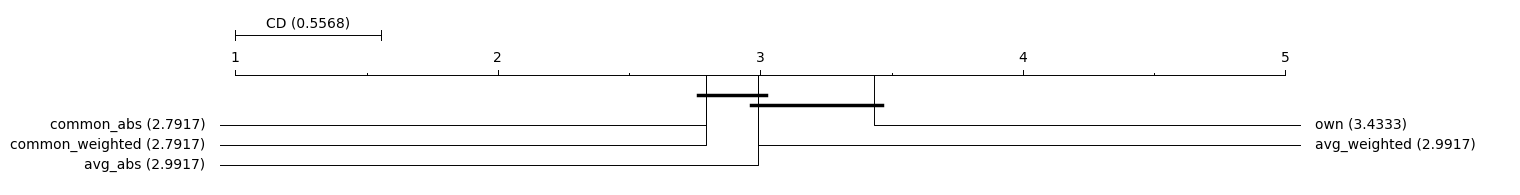

In [11]:

num_cases = acc_results2.shape[0]
ranks_values, critical_distance_nemenyi, figure = nemenyi(rankings, num_cases, alpha)
print(ranks_values)
print(critical_distance_nemenyi)
figure.show()


                        Comparison  Statistic (Z)   p-value  Adjusted alpha  \
0    common_abs vs common_weighted       0.000000  1.000000           0.005   
1                common_abs vs own       3.143512  0.001669           0.005   
2            common_abs vs avg_abs       0.979796  0.327187           0.005   
3       common_abs vs avg_weighted       0.979796  0.327187           0.005   
4           common_weighted vs own       3.143512  0.001669           0.005   
5       common_weighted vs avg_abs       0.979796  0.327187           0.005   
6  common_weighted vs avg_weighted       0.979796  0.327187           0.005   
7                   own vs avg_abs       2.163716  0.030486           0.005   
8              own vs avg_weighted       2.163716  0.030486           0.005   
9          avg_abs vs avg_weighted       0.000000  1.000000           0.005   

   Adjusted p-value  alpha            Results  
0          1.000000   0.05  Fail to Reject H0  
1          0.016693   0.05        

C:\Users\mario\AppData\Local\Temp\ipykernel_29312\844582222.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


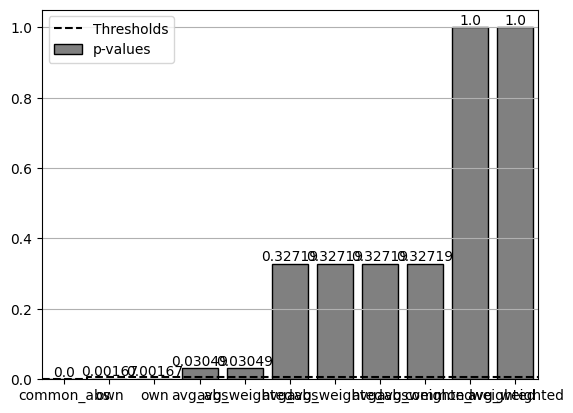

In [12]:

results, figure = bonferroni(rankings, num_cases, alpha, control = None, type_rank = "Friedman")
print(results)
figure.show()


# F1 score statistical test


In [13]:

f1_results2 = f1_results.round(decimals=3).reset_index()
alpha = 0.05
rankings, statistic, p_value, critical_value, hypothesis = friedman(f1_results2, alpha, minimize=False)
print("F1-score results:\n")
print(hypothesis)
print(f"Statistic {statistic}, p-value {p_value}")
print(rankings)


F1-score results:

Reject H0 with alpha = 0.05 (Different distributions)
Statistic 12.88000000000011, p-value 0.011877265717759933
{'common_abs': 2.8, 'common_weighted': 2.8, 'own': 3.433333333333333, 'avg_abs': 2.9833333333333334, 'avg_weighted': 2.9833333333333334}


[2.8, 2.8, 3.433333333333333, 2.9833333333333334, 2.9833333333333334]
0.5568046824928988


C:\Users\mario\AppData\Local\Temp\ipykernel_29312\2903514658.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


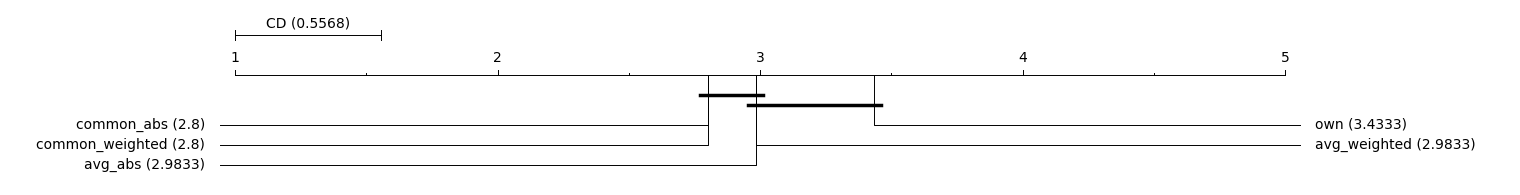

In [14]:

num_cases = f1_results2.shape[0]
ranks_values, critical_distance_nemenyi, figure = nemenyi(rankings, num_cases, alpha)
print(ranks_values)
print(critical_distance_nemenyi)
figure.show()


                        Comparison  Statistic (Z)   p-value  Adjusted alpha  \
0    common_abs vs common_weighted       0.000000  1.000000           0.005   
1                common_abs vs own       3.102687  0.001918           0.005   
2            common_abs vs avg_abs       0.898146  0.369108           0.005   
3       common_abs vs avg_weighted       0.898146  0.369108           0.005   
4           common_weighted vs own       3.102687  0.001918           0.005   
5       common_weighted vs avg_abs       0.898146  0.369108           0.005   
6  common_weighted vs avg_weighted       0.898146  0.369108           0.005   
7                   own vs avg_abs       2.204541  0.027486           0.005   
8              own vs avg_weighted       2.204541  0.027486           0.005   
9          avg_abs vs avg_weighted       0.000000  1.000000           0.005   

   Adjusted p-value  alpha            Results  
0          1.000000   0.05  Fail to Reject H0  
1          0.019177   0.05        

C:\Users\mario\AppData\Local\Temp\ipykernel_29312\2445730000.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


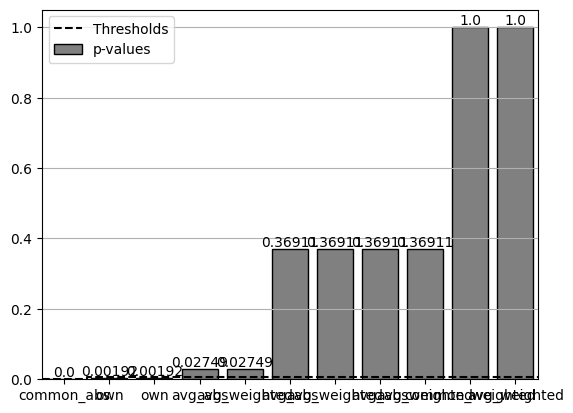

In [15]:

results, figure = bonferroni(rankings, num_cases, alpha, control = None, type_rank = "Friedman")
print(results)
figure.show()

# Non- IID quantity_skew (weighted)

In [23]:
time0 = time.time()
nidd_quantity_skew_resW = experiment2search(data_distribution='niid_quantity_skew',datasets=datasets,distribution_param=0.5)
print("\n[INFO] Total Time (in minutes) =", (time.time() - time0) / 60)
for result in nidd_quantity_skew_resW:
    print(result)

c:\Users\mario\OneDrive\Escritorio\Programs\gitProjects\TFM_EnsembleFL\.venv\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\mario\OneDrive\Escritorio\Programs\gitProjects\TFM_EnsembleFL\.venv\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\mario\OneDrive\Escritorio\Programs\gitProjects\TFM_EnsembleFL\.venv\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\mario\OneDrive\Escritorio\Programs\gitProjects\TFM_EnsembleFL\.venv\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\mario\O


[INFO] Total Time (in minutes) = 28.677382882436117
FLGlobal_acc  common_abs   c_a_std  common_weighted   c_w_std        own  \
bank           87.799831  0.789295        87.799831  0.789295  87.805877   
adult          83.220038  1.079829        83.220038  1.079829  83.024980   
nursery        95.106310  0.604819        95.109739  0.606893  93.819444   
bcancer        91.626539  3.283344        91.626539  3.197634  87.979571   

FLGlobal_acc   own_std    avg_abs   a_a_std  avg_weighted   a_w_std  
bank          0.786310  87.805877  0.786310     87.805877  0.786310  
adult         1.557379  83.200928  1.136028     83.188643  1.169972  
nursery       4.921016  94.953704  1.057963     95.021776  0.819954  
bcancer       7.097236  90.805472  4.071694     90.856680  4.028856  
FLlocal_acc  common_abs    c_a_std  common_weighted    c_w_std        own  \
bank          87.747144   4.853012        87.747144   4.853012  87.747144   
adult         83.248277   5.802296        83.248277   5.802296

# Accuracy results

In [24]:
_,_,_,_,_,_,acc_results,f1_results = nidd_quantity_skew_resW
acc_results2 = acc_results.round(decimals=3).reset_index()
alpha = 0.05
rankings, statistic, p_value, critical_value, hypothesis = friedman(acc_results2, alpha, minimize=False)
print("Accuracy results:\n")
print(hypothesis)
print(f"Statistic {statistic}, p-value {p_value}")
print(rankings)


Accuracy results:

Reject H0 with alpha = 0.05 (Different distributions)
Statistic 75.66666666666697, p-value 6.966027754629067e-11
{'common_abs': 2.4541666666666666, 'common_weighted': 2.441666666666667, 'own': 3.970833333333333, 'avg_abs': 3.154166666666667, 'avg_weighted': 2.9791666666666665}


[2.4541666666666666, 2.441666666666667, 3.970833333333333, 3.154166666666667, 2.9791666666666665]
0.5568046824928988


C:\Users\mario\AppData\Local\Temp\ipykernel_29312\2379137519.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


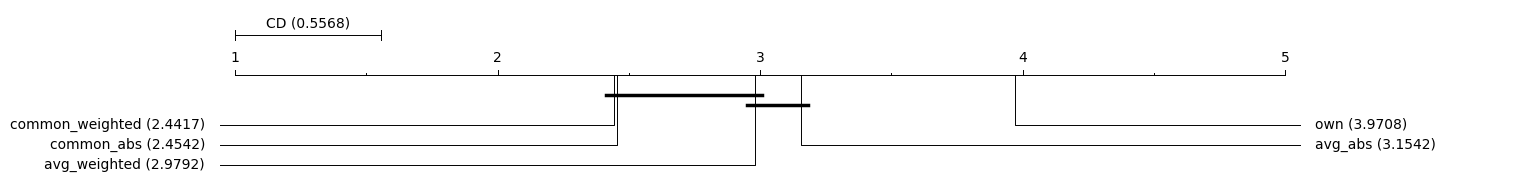

In [25]:


num_cases = acc_results2.shape[0]
ranks_values, critical_distance_nemenyi, figure = nemenyi(rankings, num_cases, alpha)
print(ranks_values)
print(critical_distance_nemenyi)
figure.show()


                        Comparison  Statistic (Z)       p-value  \
0    common_abs vs common_weighted       0.061237  9.511703e-01   
1                common_abs vs own       7.430119  1.083578e-13   
2            common_abs vs avg_abs       3.429286  6.051723e-04   
3       common_abs vs avg_weighted       2.571964  1.011233e-02   
4           common_weighted vs own       7.491356  6.816769e-14   
5       common_weighted vs avg_abs       3.490523  4.820763e-04   
6  common_weighted vs avg_weighted       2.633201  8.458416e-03   
7                   own vs avg_abs       4.000833  6.311983e-05   
8              own vs avg_weighted       4.858155  1.184848e-06   
9          avg_abs vs avg_weighted       0.857321  3.912673e-01   

   Adjusted alpha  Adjusted p-value  alpha            Results  
0           0.005      1.000000e+00   0.05  Fail to Reject H0  
1           0.005      1.083578e-12   0.05          Reject H0  
2           0.005      6.051723e-03   0.05          Reject H0  
3     

C:\Users\mario\AppData\Local\Temp\ipykernel_29312\844582222.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


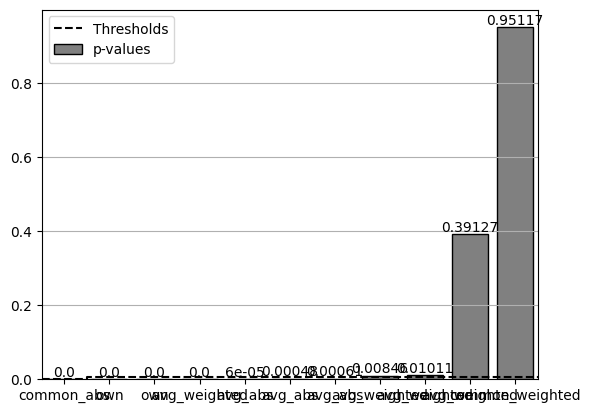

In [26]:

results, figure = bonferroni(rankings, num_cases, alpha, control = None, type_rank = "Friedman")
print(results)
figure.show()


# F1 score statistical test

In [27]:


f1_results2 = f1_results.round(decimals=3).reset_index()
alpha = 0.05
rankings, statistic, p_value, critical_value, hypothesis = friedman(f1_results2, alpha, minimize=False)
print("F1-score results:\n")
print(hypothesis)
print(f"Statistic {statistic}, p-value {p_value}")
print(rankings)


F1-score results:

Reject H0 with alpha = 0.05 (Different distributions)
Statistic 64.11666666666679, p-value 7.338840646298195e-11
{'common_abs': 2.495833333333333, 'common_weighted': 2.4791666666666665, 'own': 3.8875, 'avg_abs': 3.15, 'avg_weighted': 2.9875}


[2.495833333333333, 2.4791666666666665, 3.8875, 3.15, 2.9875]
0.5568046824928988


C:\Users\mario\AppData\Local\Temp\ipykernel_29312\2903514658.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


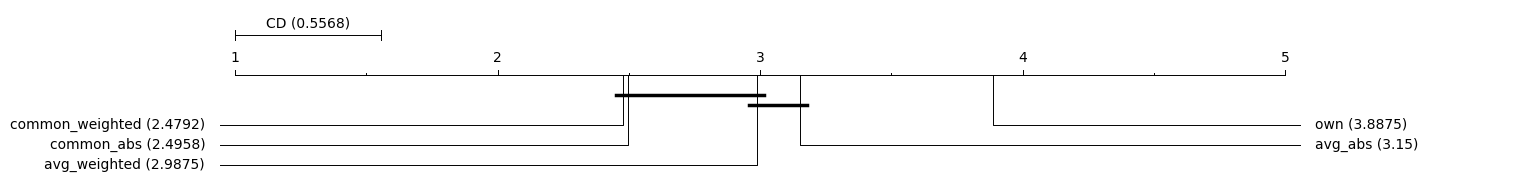

In [28]:

num_cases = f1_results2.shape[0]
ranks_values, critical_distance_nemenyi, figure = nemenyi(rankings, num_cases, alpha)
print(ranks_values)
print(critical_distance_nemenyi)
figure.show()


                        Comparison  Statistic (Z)       p-value  \
0    common_abs vs common_weighted       0.081650  9.349253e-01   
1                common_abs vs own       6.817746  9.247936e-12   
2            common_abs vs avg_abs       3.204749  1.351803e-03   
3       common_abs vs avg_weighted       2.408665  1.601099e-02   
4           common_weighted vs own       6.899396  5.222489e-12   
5       common_weighted vs avg_abs       3.286399  1.014773e-03   
6  common_weighted vs avg_weighted       2.490315  1.276301e-02   
7                   own vs avg_abs       3.612997  3.026778e-04   
8              own vs avg_weighted       4.409082  1.038099e-05   
9          avg_abs vs avg_weighted       0.796084  4.259831e-01   

   Adjusted alpha  Adjusted p-value  alpha            Results  
0           0.005      1.000000e+00   0.05  Fail to Reject H0  
1           0.005      9.247936e-11   0.05          Reject H0  
2           0.005      1.351803e-02   0.05          Reject H0  
3     

C:\Users\mario\AppData\Local\Temp\ipykernel_29312\2445730000.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


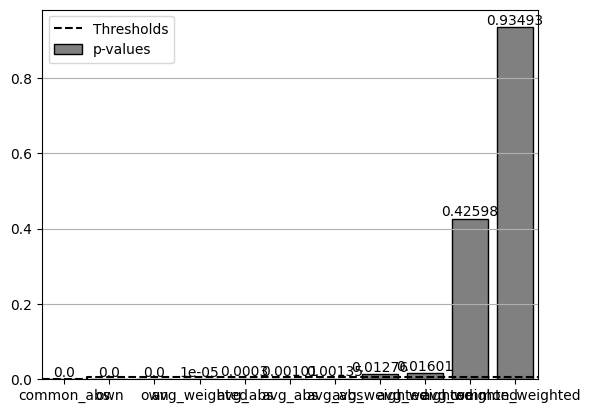

In [29]:

results, figure = bonferroni(rankings, num_cases, alpha, control = None, type_rank = "Friedman")
print(results)
figure.show()

# Non IID dirichlet_label skew (weighted)

In [37]:
time0 = time.time()
nidd_dirichlet_label_resW = experiment2search(data_distribution='niid_dirichlet_label_skew',datasets=datasets,distribution_param=0.5)
print("\n[INFO] Total Time (in minutes) =", (time.time() - time0) / 60)
for result in nidd_dirichlet_label_resW:
    print(result)

c:\Users\mario\OneDrive\Escritorio\Programs\gitProjects\TFM_EnsembleFL\.venv\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\mario\OneDrive\Escritorio\Programs\gitProjects\TFM_EnsembleFL\.venv\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\mario\OneDrive\Escritorio\Programs\gitProjects\TFM_EnsembleFL\.venv\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\mario\OneDrive\Escritorio\Programs\gitProjects\TFM_EnsembleFL\.venv\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\mario\O


[INFO] Total Time (in minutes) = 25.692602491378786
FLGlobal_acc  common_abs   c_a_std  common_weighted   c_w_std        own  \
bank           88.154213  0.381517        88.154213  0.381517  88.190834   
adult          82.908818  0.882277        81.898717  2.599629  81.690145   
nursery        92.825789  1.257405        92.812071  1.282851  92.149863   
bcancer        90.067487  2.923446        90.420429  3.183204  83.032741   

FLGlobal_acc    own_std    avg_abs   a_a_std  avg_weighted   a_w_std  
bank           0.349282  88.171515  0.373776     88.171515  0.373776  
adult          2.748447  82.171035  2.266164     81.779962  2.623618  
nursery        3.133006  92.754801  1.460740     92.699931  1.667127  
bcancer       10.824641  85.759280  8.783491     85.955449  8.860044  
FLlocal_acc  common_abs    c_a_std  common_weighted    c_w_std        own  \
bank          79.164205  25.692895        79.164205  25.692895  76.839971   
adult         78.157125  18.629172        76.133683  22.6

# Accuracy results

In [38]:
_,_,_,_,_,_,acc_results,f1_results = nidd_dirichlet_label_resW
acc_results2 = acc_results.round(decimals=3).reset_index()
alpha = 0.05
rankings, statistic, p_value, critical_value, hypothesis = friedman(acc_results2, alpha, minimize=False)
print("Accuracy results:\n")
print(hypothesis)
print(f"Statistic {statistic}, p-value {p_value}")
print(rankings)


Accuracy results:

Reject H0 with alpha = 0.05 (Different distributions)
Statistic 97.62833333333356, p-value 9.291745151074338e-11
{'common_abs': 2.2666666666666666, 'common_weighted': 2.433333333333333, 'own': 4.066666666666666, 'avg_abs': 3.0458333333333334, 'avg_weighted': 3.1875}


[2.2666666666666666, 2.433333333333333, 4.066666666666666, 3.0458333333333334, 3.1875]
0.5568046824928988


C:\Users\mario\AppData\Local\Temp\ipykernel_29312\2379137519.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


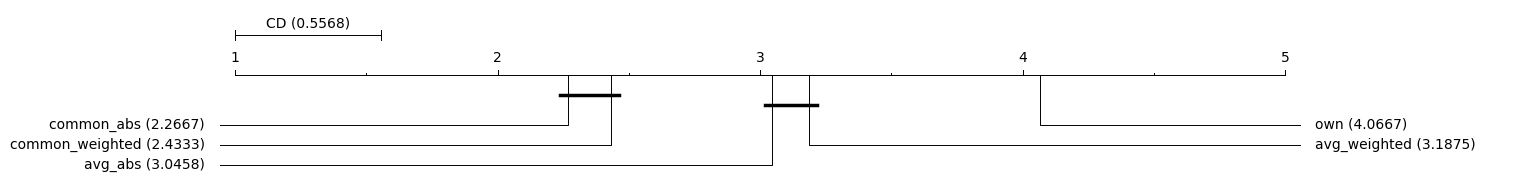

In [39]:


num_cases = acc_results2.shape[0]
ranks_values, critical_distance_nemenyi, figure = nemenyi(rankings, num_cases, alpha)
print(ranks_values)
print(critical_distance_nemenyi)
figure.show()


                        Comparison  Statistic (Z)       p-value  \
0    common_abs vs common_weighted       0.816497  4.142162e-01   
1                common_abs vs own       8.818163  0.000000e+00   
2            common_abs vs avg_abs       3.817122  1.350177e-04   
3       common_abs vs avg_weighted       4.511144  6.447905e-06   
4           common_weighted vs own       8.001666  1.332268e-15   
5       common_weighted vs avg_abs       3.000625  2.694262e-03   
6  common_weighted vs avg_weighted       3.694647  2.201925e-04   
7                   own vs avg_abs       5.001042  5.702142e-07   
8              own vs avg_weighted       4.307019  1.654691e-05   
9          avg_abs vs avg_weighted       0.694022  4.876684e-01   

   Adjusted alpha  Adjusted p-value  alpha            Results  
0           0.005      1.000000e+00   0.05  Fail to Reject H0  
1           0.005      0.000000e+00   0.05          Reject H0  
2           0.005      1.350177e-03   0.05          Reject H0  
3     

C:\Users\mario\AppData\Local\Temp\ipykernel_29312\844582222.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


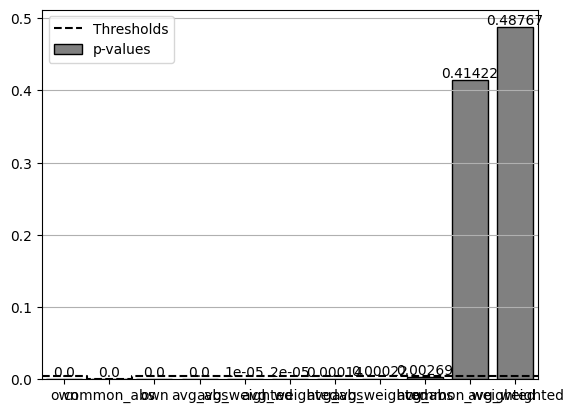

In [40]:

results, figure = bonferroni(rankings, num_cases, alpha, control = None, type_rank = "Friedman")
print(results)
figure.show()


# F1 score statistical test


In [41]:

f1_results2 = f1_results.round(decimals=3).reset_index()
alpha = 0.05
rankings, statistic, p_value, critical_value, hypothesis = friedman(f1_results2, alpha, minimize=False)
print("F1-score results:\n")
print(hypothesis)
print(f"Statistic {statistic}, p-value {p_value}")
print(rankings)


F1-score results:

Fail to Reject H0 with alpha = 0.05 (Same distributions)
Statistic 1.2800000000002, p-value 0.864759575430834
{'common_abs': 3.0416666666666665, 'common_weighted': 2.875, 'own': 3.091666666666667, 'avg_abs': 2.975, 'avg_weighted': 3.0166666666666666}


[3.0416666666666665, 2.875, 3.091666666666667, 2.975, 3.0166666666666666]
0.5568046824928988


C:\Users\mario\AppData\Local\Temp\ipykernel_29312\2903514658.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


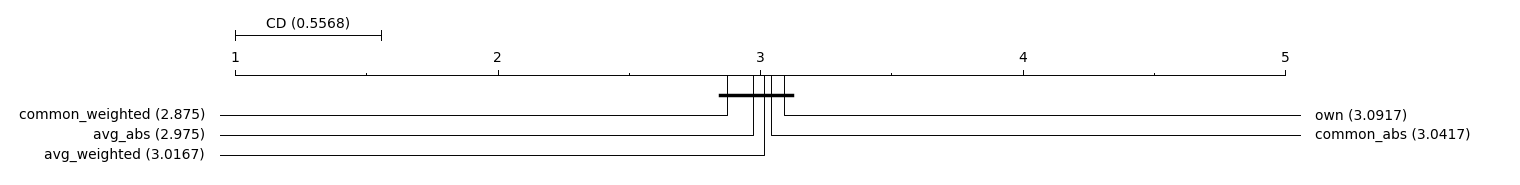

In [42]:

num_cases = f1_results2.shape[0]
ranks_values, critical_distance_nemenyi, figure = nemenyi(rankings, num_cases, alpha)
print(ranks_values)
print(critical_distance_nemenyi)
figure.show()


                        Comparison  Statistic (Z)   p-value  Adjusted alpha  \
0    common_abs vs common_weighted       0.816497  0.414216           0.005   
1                common_abs vs own       0.244949  0.806496           0.005   
2            common_abs vs avg_abs       0.326599  0.743971           0.005   
3       common_abs vs avg_weighted       0.122474  0.902523           0.005   
4           common_weighted vs own       1.061446  0.288487           0.005   
5       common_weighted vs avg_abs       0.489898  0.624206           0.005   
6  common_weighted vs avg_weighted       0.694022  0.487668           0.005   
7                   own vs avg_abs       0.571548  0.567628           0.005   
8              own vs avg_weighted       0.367423  0.713303           0.005   
9          avg_abs vs avg_weighted       0.204124  0.838256           0.005   

   Adjusted p-value  alpha            Results  
0                 1   0.05  Fail to Reject H0  
1                 1   0.05  Fail t

C:\Users\mario\AppData\Local\Temp\ipykernel_29312\2445730000.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


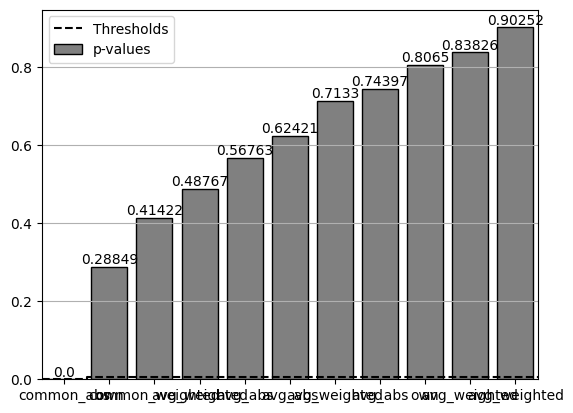

In [43]:

results, figure = bonferroni(rankings, num_cases, alpha, control = None, type_rank = "Friedman")
print(results)
figure.show()

# Non IID label quantity skew (weighted)

In [51]:
dataset = {'nursery':(X_data_nursery,targets_nursery)} #Only nursery bc it is the only one with more than 2 labels
time0 = time.time()
nidd_label_quantity_resW = experiment2search(data_distribution='niid_label_quantity_skew',datasets=dataset,distribution_param=3)
print("\n[INFO] Total Time (in minutes) =", (time.time() - time0) / 60)
for result in nidd_label_quantity_resW:
    print(result)

c:\Users\mario\OneDrive\Escritorio\Programs\gitProjects\TFM_EnsembleFL\.venv\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


c:\Users\mario\OneDrive\Escritorio\Programs\gitProjects\TFM_EnsembleFL\.venv\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\mario\OneDrive\Escritorio\Programs\gitProjects\TFM_EnsembleFL\.venv\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\mario\OneDrive\Escritorio\Programs\gitProjects\TFM_EnsembleFL\.venv\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\mario\OneDrive\Escritorio\Programs\gitProjects\TFM_EnsembleFL\.venv\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\mario\O


[INFO] Total Time (in minutes) = 3.6073421319325765
FLGlobal_acc  common_abs   c_a_std  common_weighted   c_w_std        own  \
nursery        92.608025  1.392554        92.608025  1.392554  91.688615   

FLGlobal_acc   own_std    avg_abs   a_a_std  avg_weighted   a_w_std  
nursery       5.225142  92.592078  1.394732     92.585391  1.397696  
FLlocal_acc  common_abs    c_a_std  common_weighted    c_w_std      own  \
nursery       90.592221  11.233496        90.592221  11.233496  90.0918   

FLlocal_acc    own_std    avg_abs    a_a_std  avg_weighted    a_w_std  
nursery      12.163046  90.588984  11.232038     90.585108  11.230225  
centralized_acc       mean       std
nursery          99.278121  0.247585
FLGlobal_f1  common_abs   c_a_std  common_weighted   c_w_std        own  \
nursery       93.259785  1.169405        93.259785  1.169405  92.458909   

FLGlobal_f1   own_std    avg_abs   a_a_std  avg_weighted   a_w_std  
nursery      4.003727  93.244131  1.176418     93.237576  1.17958

# Accuracy results

In [52]:
_,_,_,_,_,_,acc_results,f1_results = nidd_label_quantity_resW
acc_results2 = acc_results.round(decimals=3).reset_index()
alpha = 0.05
rankings, statistic, p_value, critical_value, hypothesis = friedman(acc_results2, alpha, minimize=False)
print("Accuracy results:\n")
print(hypothesis)
print(f"Statistic {statistic}, p-value {p_value}")
print(rankings)


Accuracy results:

Reject H0 with alpha = 0.05 (Different distributions)
Statistic 48.5, p-value 7.833361737041855e-10
{'common_abs': 2.25, 'common_weighted': 2.25, 'own': 4.666666666666667, 'avg_abs': 2.6666666666666665, 'avg_weighted': 3.1666666666666665}


[2.25, 2.25, 4.666666666666667, 2.6666666666666665, 3.1666666666666665]
1.1136093649857977


C:\Users\mario\AppData\Local\Temp\ipykernel_29312\2379137519.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


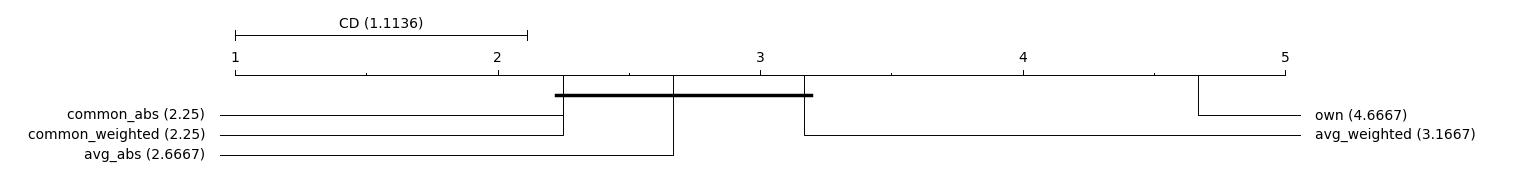

In [53]:


num_cases = acc_results2.shape[0]
ranks_values, critical_distance_nemenyi, figure = nemenyi(rankings, num_cases, alpha)
print(ranks_values)
print(critical_distance_nemenyi)
figure.show()


                        Comparison  Statistic (Z)       p-value  \
0    common_abs vs common_weighted       0.000000  1.000000e+00   
1                common_abs vs own       5.919600  3.227251e-09   
2            common_abs vs avg_abs       1.020621  3.074342e-01   
3       common_abs vs avg_weighted       2.245366  2.474467e-02   
4           common_weighted vs own       5.919600  3.227251e-09   
5       common_weighted vs avg_abs       1.020621  3.074342e-01   
6  common_weighted vs avg_weighted       2.245366  2.474467e-02   
7                   own vs avg_abs       4.898979  9.633570e-07   
8              own vs avg_weighted       3.674235  2.385635e-04   
9          avg_abs vs avg_weighted       1.224745  2.206714e-01   

   Adjusted alpha  Adjusted p-value  alpha            Results  
0           0.005      1.000000e+00   0.05  Fail to Reject H0  
1           0.005      3.227251e-08   0.05          Reject H0  
2           0.005      1.000000e+00   0.05  Fail to Reject H0  
3     

C:\Users\mario\AppData\Local\Temp\ipykernel_29312\844582222.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


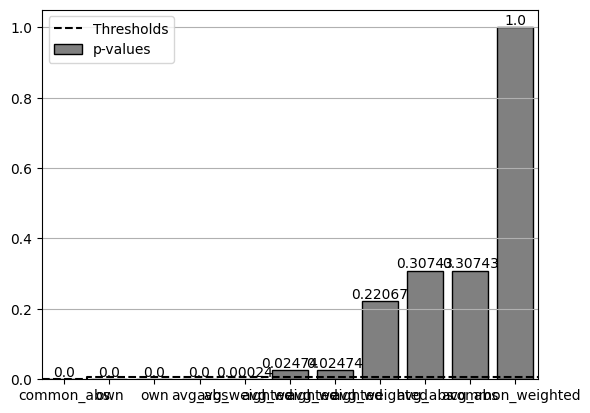

In [54]:

results, figure = bonferroni(rankings, num_cases, alpha, control = None, type_rank = "Friedman")
print(results)
figure.show()


# F1 score statistical test


In [55]:

f1_results2 = f1_results.round(decimals=3).reset_index()
alpha = 0.05
rankings, statistic, p_value, critical_value, hypothesis = friedman(f1_results2, alpha, minimize=False)
print("F1-score results:\n")
print(hypothesis)
print(f"Statistic {statistic}, p-value {p_value}")
print(rankings)


F1-score results:

Reject H0 with alpha = 0.05 (Different distributions)
Statistic 48.5, p-value 7.833361737041855e-10
{'common_abs': 2.25, 'common_weighted': 2.25, 'own': 4.666666666666667, 'avg_abs': 2.6666666666666665, 'avg_weighted': 3.1666666666666665}


[2.25, 2.25, 4.666666666666667, 2.6666666666666665, 3.1666666666666665]
1.1136093649857977


C:\Users\mario\AppData\Local\Temp\ipykernel_29312\2903514658.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


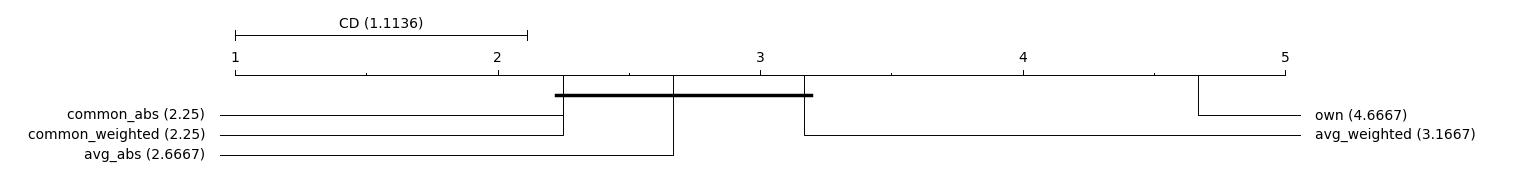

In [56]:

num_cases = f1_results2.shape[0]
ranks_values, critical_distance_nemenyi, figure = nemenyi(rankings, num_cases, alpha)
print(ranks_values)
print(critical_distance_nemenyi)
figure.show()


                        Comparison  Statistic (Z)       p-value  \
0    common_abs vs common_weighted       0.000000  1.000000e+00   
1                common_abs vs own       5.919600  3.227251e-09   
2            common_abs vs avg_abs       1.020621  3.074342e-01   
3       common_abs vs avg_weighted       2.245366  2.474467e-02   
4           common_weighted vs own       5.919600  3.227251e-09   
5       common_weighted vs avg_abs       1.020621  3.074342e-01   
6  common_weighted vs avg_weighted       2.245366  2.474467e-02   
7                   own vs avg_abs       4.898979  9.633570e-07   
8              own vs avg_weighted       3.674235  2.385635e-04   
9          avg_abs vs avg_weighted       1.224745  2.206714e-01   

   Adjusted alpha  Adjusted p-value  alpha            Results  
0           0.005      1.000000e+00   0.05  Fail to Reject H0  
1           0.005      3.227251e-08   0.05          Reject H0  
2           0.005      1.000000e+00   0.05  Fail to Reject H0  
3     

C:\Users\mario\AppData\Local\Temp\ipykernel_29312\2445730000.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


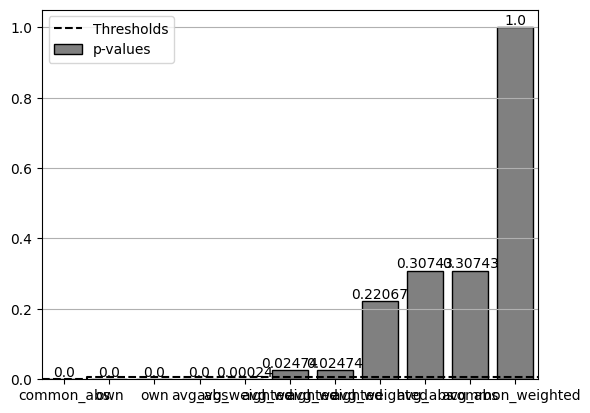

In [57]:

results, figure = bonferroni(rankings, num_cases, alpha, control = None, type_rank = "Friedman")
print(results)
figure.show()